In [1]:
from ROOT import TFile, gDirectory
import ROOT as r
import os
import datetime

Welcome to JupyROOT 6.16/00


In [2]:
%%time
#test if kernel is running

print('running')

running
CPU times: user 574 µs, sys: 986 µs, total: 1.56 ms
Wall time: 1.58 ms


# Todo

* [DONE]Add plots for number of b-tagged jets
* Check number of jets
* [DONE] extend MET plot range until no overflow 
* [DONE] fix ratio scaling on log plots


* get total sum weight of all the files (>2) # of weighted entries
* [DONE] fix the loops so that there is only one and add a flag for data/mc to do the weighting 
* [DONE] Create correction function of HT to get HT ratio ~1, make sure other rations remain unchanged, use tf1 fit or roofit
* evaluate function of HT by making ratio comparison plots for the mc original and mc corrected
* consider cutting off the function fit at certain HT value and flat after or adjusting bin sizes to reduce uncertainty, then fit 
* plot signal and background on same plot and look for critical values for seperation - these are to be used as cuts later

# Cuts
* high ht - must look at signal to know
* large # of b jets (test 3 and 4)
* large # of jets
* for each cut, calcualte signal / sqrt(signal + bkg) and find cut to maximize this value 
* look at distributions by normalizing both to one (a first order approx)


# Outline of Notebook
* All function defns
* Initlalize chains and hists
* Build correction function from ht
* Refill new corrected histograms
* Make good cuts based on bkg ONLY
* Plot signal and bkg hists

Build files into TChain

# FUNCTIONS

In [3]:
#use lum = 140
def GetWeight(lumi,tree, corr_poly = None):
    #w = lumi * 1000 * tree.weight_normalise *  tree.weight_mc *  tree.weight_pileup *tree.weight_leptonSF *  tree.weight_bTagSF_MV2c10_77 *  tree.weight_jvt
    w = ((43.5938/127.64416)*(tree.runNumber == 300000)+(36.20766/127.64416)*(tree.runNumber == 284500)+(47.8427/127.64416)*(tree.runNumber == 310000))*tree.weight_normalise*tree.weight_mc*tree.weight_pileup*tree.weight_leptonSF*tree.weight_bTagSF_MV2c10_70*127.65516*1000*(tree.nBTags_MV2c10_70>1)
    
    if corr_poly:
        w_ht_corrected = w / corr_poly.Eval(tree.HT_all)
        return w_ht_corrected
   
    else: return w

def poly_ht(func, ht):
    pol =  func.Parameter(0) + func.Parameter(1)*ht + func.Parameter(2)* ht**2 + func.Parameter(3)* ht**3 + func.Parameter(4) * ht**4 + func.Parameter(5)*ht**5
    return pol

In [4]:
def fill_hists(chain, entries, run_type, poly= None, save_hists = False, cuts =['bjets_mc70 <= 2']):
    
    for jentry in range(entries):
        nb = chain.GetEntry(jentry)
    
        if nb<=0: continue
        
        jet_pt = chain.jet_pt[0]
        met = chain.met_met
        #mu_pt = mc_chain.mu_pt
        ht_all = chain.HT_all
        bjets_mc70 = chain.nBTags_MV2c10_70
        njets = chain.nJets

        #add conditions here
        for cut in cuts:
            if eval(cut) == True: 
                continue 
        #if (bjets_mc70 < 2): continue
        
        if run_type == 'data': 
            met_data.Fill(met)
            jet_pt_data.Fill(jet_pt)
            ht_all_data.Fill(ht_all)
            bjets_data.Fill(bjets_mc70)
            njets_data.Fill(njets)

        elif run_type == 'bkg_corr':
            try:
                weight = GetWeight(140, chain, corr_poly = poly)
            except:
                print("MC corrected requires a function to exectute")
                break
                
            met_bkg_corr.Fill(met,weight)
            jet_pt_bkg_corr.Fill(jet_pt, weight)
            ht_all_bkg_corr.Fill(ht_all, weight)
            bjets_bkg_corr.Fill(bjets_mc70, weight)
            njets_bkg_corr.Fill(njets, weight)
            
        elif run_type == 'signal':
            weight = GetWeight(140, chain)
            
            met_sig.Fill(met, weight)
            ht_all_sig.Fill(ht_all, weight)
            jet_pt_sig.Fill(jet_pt, weight)
            bjets_sig.Fill(bjets_mc70, weight)
            njets_sig.Fill(njets, weight)
             
        elif run_type == 'bkg':
            weight = GetWeight(140, chain)
            
            met_bkg.Fill(met,weight)
            jet_pt_bkg.Fill(jet_pt, weight)
            ht_all_bkg.Fill(ht_all, weight)
            bjets_bkg.Fill(bjets_mc70, weight)
            njets_bkg.Fill(njets, weight)
            
    if save_hists == True:
        time = datetime.datetime.now().strftime("%y-%m-%d+%H_%M")
        if run_type == 'data':
            met_data.SaveAs('met_data_' + time + '.root')
            jet_pt_data.SaveAs('jetpt_data_' + time + '.root')
            ht_all_data.SaveAs('htall_data_' + time + '.root')
            bjets_data.SaveAs('bjets_data_' + time + '.root')
            njets_data.SaveAs('njets_data_'+time+'.root')
            
        elif run_type == 'bkg_corr':
            met_bkg_corr.SaveAs('met_bkg_corr_' + time + '.root')
            jet_pt_bkg_corr.SaveAs('jetpt_bkg_corr_' + time + '.root')
            ht_all_bkg_corr.SaveAs('htall_bkg_corr_' + time + '.root')
            bjets_bkg_corr.SaveAs('bjets_bkg_corr_' + time + '.root')
            njets_bkg_corr.SaveAs('njets_bkg_corr_' + time + '.root')
            
        elif run_type == 'signal':
            met_sig.SaveAs('met_sig_' +time+'.root')
            jet_pt_sig.SaveAs('jetpt_sig_' +time+'.root')
            ht_all_sig.SaveAs('htall_sig_' +time+'.root')
            bjets_sig.SaveAs('bjets_sig_' +time+'.root')
            njets_sig.SaveAs('njets_sig_' +time+'.root')
            
        elif run_type == 'bkg':
            met_bkg.SaveAs('met_bkg_' + time + '.root')
            jet_pt_bkg.SaveAs('jetpt_bkg_' + time + '.root')
            ht_all_bkg.SaveAs('htall_bkg_' + time + '.root')
            bjets_bkg.SaveAs('bjets_bkg_' + time + '.root')
            njets_bkg.SaveAs('njets_bkg_'+time+'.root')

In [5]:
def make_ratio_hists(bkg_hist, data_hist, save_name, draw = True , log = False):
    c = r.TCanvas()
    
    rp = r.TRatioPlot(bkg_hist, data_hist)
    rp.Draw()

    if log == True:
        c.SetLogy(1)
    lower_y = rp.GetLowerRefYaxis()
    
    lower_y.SetTitle('MC/Data')
    lower_y.SetRangeUser(0,2)

    if draw == True:
        c.Draw()
        
    c.SaveAs(save_name + '.root')
    c.Close()
    r.gSystem.ProcessEvents()
    
def make_ratio_compare_hists(mc_original, mc_corr_original, data, save_name, draw = True):
    
    c = r.TCanvas()
        
    mc = mc_original.Clone()
    mc_corr = mc_corr_original.Clone()
    
    mc.Divide(data)
    mc_corr.Divide(data)
    
    mc_corr.SetLineColor(4)
    mc_corr.Draw()
    mc.SetLineColor(2)
    mc.Draw("SAME")
    
    if draw== True:
        c.Draw()

    c.SaveAs(save_name + '.root')
    c.Close()
    r.gSystem.ProcessEvents()
    
def test_corr_fn(data_chain, mc_chain):
    
    fill_hists(data_chain, data_entries, run_type = 'data', poly = None)
    fill_hists(bkg_chain, bkg_entries, run_type = 'bkg', poly = None)
    
    #clone ht_all, call divide from data, fit divided, pass fn to corr_hists
    ht_ratio = ht_all_bkg.Clone()
    
    ht_ratio.Divide(ht_all_data)
    
    ht_ratio.Fit('pol5','S')
    
    ht_fit = ht_ratio.GetFunction('pol5')
    
    ht_ratio.SaveAs('fit_hist_'+ datetime.datetime.now().strftime("%y-%m-%d+%H_%M")+ '.root')
    
    fill_hists(bkg_chain, bkg_entries, run_type = 'bkg_corr', poly = ht_fit, save_hists=True)

def make_sig_bkg_stack(bkg_hist, sig_hist, save_fname , title = ''):
    stack = r.THStack()
    stack.Add(bkg_hist)
    stack.Add(sig_hist)
    
    stack.SaveAs(save_fname + '.root')
    

# Initilization

## Initilize Chains

In [6]:
%%time
filename = 'ttbar_nonallhad_HF_PhPy8_AFII_mc16a.root'
treename = 'nominal_Loose'

list_of_files = os.listdir('../data_ttbar/')
data_files = [f for f in list_of_files if 'data' in f]
bkg_files = [ 'ttbar_nonallhad_incl_PhPy8_AFII_mc16a.root', 'ttbar_nonallhad_incl_PhPy8_AFII_mc16d.root','ttbar_nonallhad_incl_PhPy8_AFII_mc16e.root',
            'ttX_mc16e.root','ttX_mc16d.root','ttX_mc16a.root',
            'vjets_Sherpa_mc16e.root','vjets_Sherpa_mc16d.root', 'vjets_Sherpa_mc16a.root',
            'singleTop_mc16e.root','singleTop_mc16d.root','singleTop_mc16a.root',
            'multiV_mc16a.root','multiV_mc16d.root','multiV_mc16e.root']

signal_files = ['4tops_Mg5Py8_AFII_mc16a.root','4tops_Mg5Py8_AFII_mc16d.root','4tops_Mg5Py8_AFII_mc16e.root']
#data_files = ['data15_AllYear.root']
#mc_files = ['ttbar_nonallhad_HF_PhPy8_AFII_mc16d.root']

data_chain = r.TChain(treename)
bkg_chain = r.TChain(treename)
signal_chain = r.TChain(treename)

for f in data_files:
    data_chain.Add('../data_ttbar/'+f)
for f in bkg_files:
    bkg_chain.Add('../data_ttbar/'+ f)
for f in signal_files:
    signal_chain.Add('../data_ttbar/'+ f)

data_entries = data_chain.GetEntries()
bkg_entries = bkg_chain.GetEntries()
signal_entries = signal_chain.GetEntries()

print(f'There are: \n{data_entries} data events \n{bkg_entries} mc events \n{signal_entries} signal events \n\n')



There are: 
3223533 data events 
23130773 mc events 
3661752 signal events 


CPU times: user 196 ms, sys: 37.4 ms, total: 234 ms
Wall time: 288 ms


## Initialize histograms

In [7]:
#####
#Set Up Code
#####

#mc_corr are mc background filled with ht-corrected weight
#mc are mc background filled with uncorrected weight
#data are data files

met_bkg = r.TH1D('met_bkg', 'E^{T}_{miss}', 100, 0, 1.2*10**6)
met_bkg_corr = r.TH1D('met_bkg_corr', 'E^{T}_{miss}', 100, 0, 1.2*10**6)
met_data = r.TH1D('met_data', 'E^T_{miss}', 100, 0, 1.2*10**6)
met_sig = r.TH1D('met_sig', 'E^T_{miss}', 100, 0, 1.2*10**6)

jet_pt_data = r.TH1D('jet_pt_data', 'jet_{pt}', 100, 0, 2*10**6)
jet_pt_bkg = r.TH1D('jet_pt_bkg', 'jet_{pt}', 100, 0, 2*10**6)
jet_pt_bkg_corr = r.TH1D('jet_pt_bkg_corr', 'jet_{pt}', 100, 0, 2*10**6)
jet_pt_sig = r.TH1D('jet_pt_sig', 'jet_{pt}', 100, 0, 2*10**6)

"""
mu_pt_mc = r.TH1D('mu_pt_bkg', '\mu_{pt}', 100, 0, 1000*10**3)
mu_pt_mc_corr = r.TH1D('mu_pt_bkg_corr', '\mu_{pt}', 100, 0, 1000*10**3)
mu_pt_data = r.TH1D('mu_pt_data', '\mu_{pt}', 100, 0, 1000*10**3)
"""

ht_all_bkg = r.TH1D('ht_all_bkg', 'H_{t}', 100, 0, 6000*10**3)
ht_all_bkg_corr = r.TH1D('ht_all_bkg_corr', 'H_{t}', 100, 0, 6000*10**3)
ht_all_data = r.TH1D('ht_all_data', '\H_{t}', 100, 0, 6000*10**3)
ht_all_sig = r.TH1D('ht_all_sig', '\H_{t}', 100, 0, 6000*10**3)

bjets_bkg = r.TH1D('bjets_bkg', 'Number of B Jets', 7,0,7)
bjets_bkg_corr = r.TH1D('bjets_bkg_corr', 'Number of B Jets', 7,0,7)
bjets_data = r.TH1D('bjets_data', 'Number of B Jets', 7,0,7)
bjets_sig = r.TH1D('bjets_sig', 'Number of B Jets', 7,0,7)

njets_bkg = r.TH1D('njets_bkg', 'Number of Jets', 20,0,20)
njets_data = r.TH1D('njets_data', 'Number of Jets', 20,0,20)
njets_sig = r.TH1D('njets_sig', 'Number of Jets', 20,0,20)
njets_bkg_corr = r.TH1D('njets_bkg_corr', 'Number of Jets', 20,0,20)

 # Fill histograms

In [8]:
%%time
fit_fn = test_corr_fn(data_chain, bkg_chain)
fill_hists(signal_chain, signal_entries, run_type='signal',save_hists=True)

for var in ['met', 'jet_pt', 'ht_all', 'bjets', 'njets']:
    time = datetime.datetime.now().strftime("%y-%m-%d+%H_%M")
    eval_string = f'make_sig_bkg_stack({var}_bkg,{var}_sig, "{var}_sig_bkg_{time}", "{var}_sig_bkg_stack")'
    exec(eval_string)

CPU times: user 1h 30min 1s, sys: 4min 1s, total: 1h 34min 2s
Wall time: 1h 34min 12s

****************************************
Minimizer is Linear
Chi2                      =      161.125
NDf                       =           65
p0                        =     0.681314   +/-   0.00530197  
p1                        =  4.21753e-07   +/-   2.95257e-08 
p2                        = -5.61092e-13   +/-   5.35999e-14 
p3                        =  4.03485e-19   +/-   3.84825e-20 
p4                        = -1.16642e-25   +/-   1.09023e-26 
p5                        =  1.08019e-32   +/-   1.04709e-33 


Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1
Info in <TH1D::SaveAs>: ROOT file fit_hist_19-04-19+00_58.root has been created
Info in <TH1D::SaveAs>: ROOT file met_bkg_corr_19-04-19+01_41.root has been created
Info in <TH1D::SaveAs>: ROOT file jetpt_bkg_corr_19-04-19+01_41.root has been created
Info in <TH1D::SaveAs>: ROOT file htall_bkg_corr_19-04-19+01_41.root has been created
Info in <TH1D::SaveAs>: ROOT file bjets_bkg_corr_19-04-19+01_41.root has been created
Info in <TH1D::SaveAs>: ROOT file njets_bkg_corr_19-04-19+01_41.root has been created
Info in <TH1D::SaveAs>: ROOT file met_sig_19-04-19+01_47.root has been created
Info in <TH1D::SaveAs>: ROOT file jetpt_sig_19-04-19+01_47.root has been created
Info in <TH1D::SaveAs>: ROOT file htall_sig_19-04-19+01_47.root has been created
Info in <TH1D::SaveAs>: ROOT file bjets_sig_19-04-19+01_47.root has been created
Info in <TH1D::SaveAs>: ROOT file njets_sig_19-04-19+01_47.root has been created
Info in <THStack:

In [18]:
c3 = r.TCanvas()

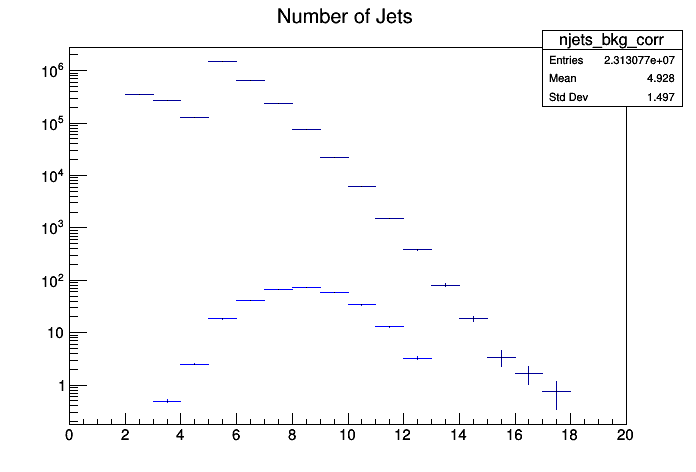

In [23]:
njets_bkg_corr.Draw()
njets_sig.SetLineColor(4)
njets_sig.Draw("SAME")
c3.SetLogy()
c3.Draw()

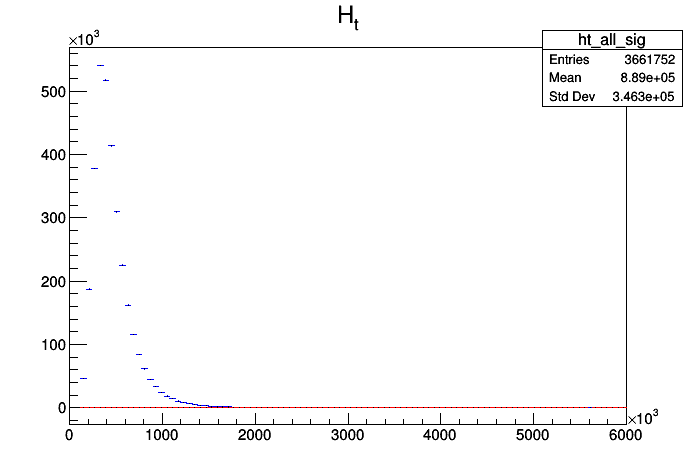

In [21]:
c_ht = r. TCanvas()
ht_all_bkg_corr.SetLineColor(4)
ht_all_bkg_corr.Draw()
ht_all_sig.SetLineColor(2)
ht_all_sig.Draw('same')
c_ht.Draw()


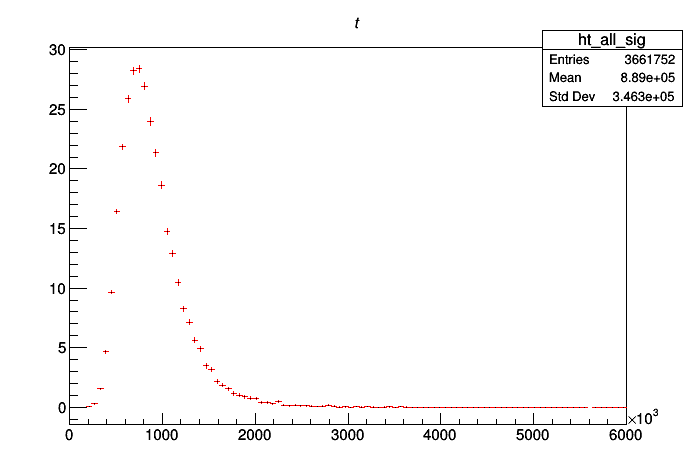

In [22]:
c_sig = r.TCanvas()
ht_all_sig.Draw()
c_sig.Draw()

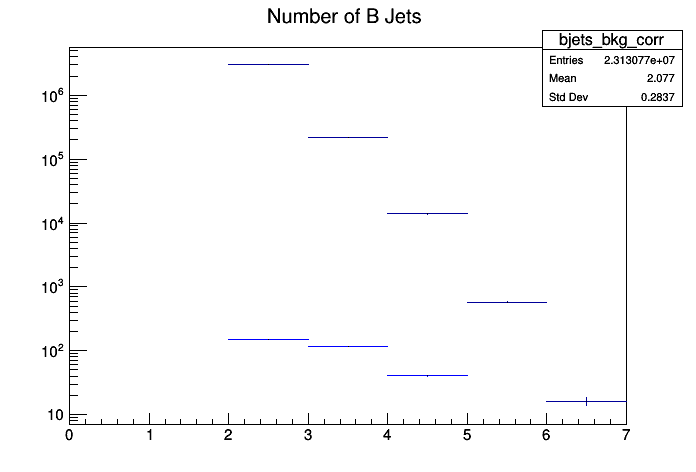

In [25]:
c4 = r.TCanvas()
bjets_bkg_corr.Draw()
bjets_sig.SetLineColor(4)
bjets_sig.Draw("SAME")
c4.SetLogy()
c4.Draw()

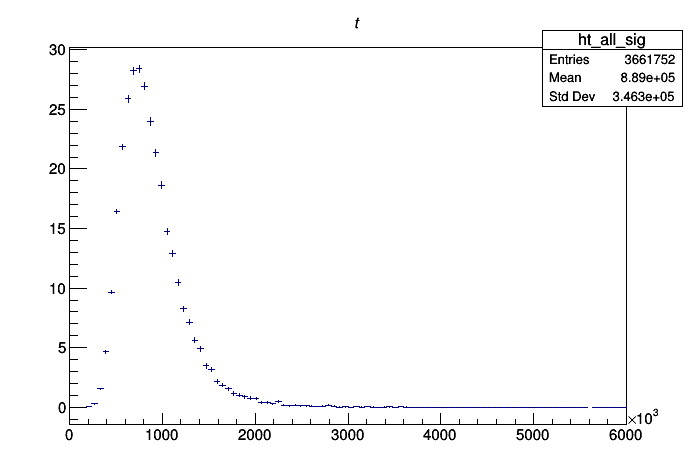

In [31]:
c = r.TCanvas()
ht_all_sig.Draw()
#ht_all_bkg.Draw("SAME")
c.Draw()

In [10]:
make_ratio_compare_hists(jet_pt_bkg, jet_pt_bkg_corr, jet_pt_data,'jet_pt_ratio', draw=False)
make_ratio_compare_hists(met_bkg, met_bkg_corr, met_data,'met_ratio', draw=False)
make_ratio_compare_hists(ht_all_bkg, ht_all_bkg_corr, ht_all_data,'ht_all_ratio', draw=False)
make_ratio_compare_hists(bjets_bkg, bjets_bkg_corr, bjets_data,'bjets_ratio', draw=False)

Info in <TCanvas::SaveAs>: ROOT file jet_pt_ratio.root has been created
Info in <TCanvas::SaveAs>: ROOT file met_ratio.root has been created
Info in <TCanvas::SaveAs>: ROOT file ht_all_ratio.root has been created
Info in <TCanvas::SaveAs>: ROOT file bjets_ratio.root has been created


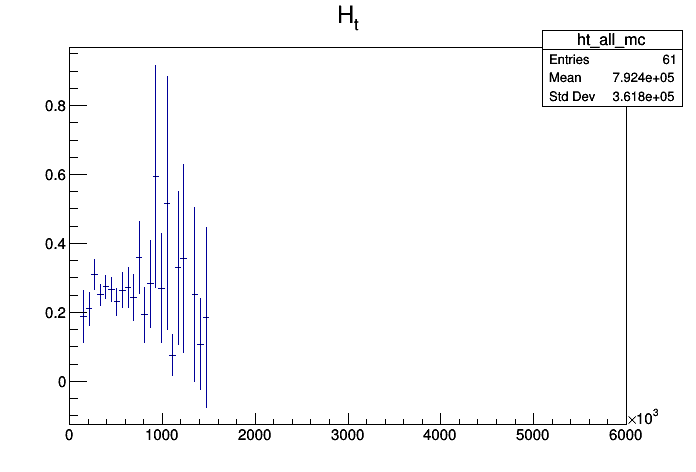

In [11]:
c_corr = r.TCanvas()


ht_ratio = ht_all_mc.Clone()
    
ht_ratio.Divide(ht_all_data)
        
ht_ratio.Draw()
    
c_corr.Draw()

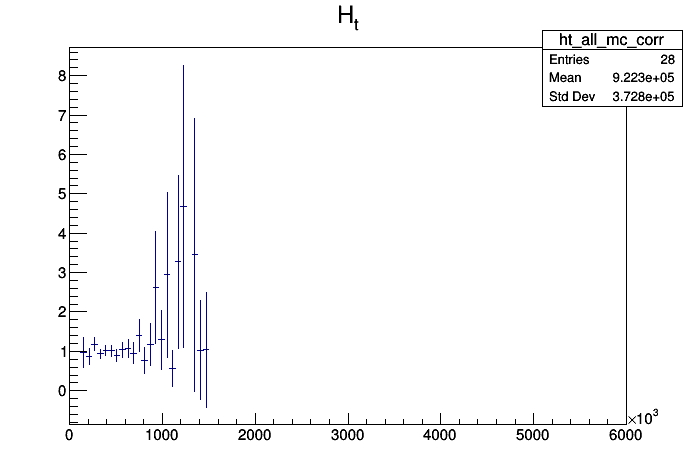

In [13]:
c_c = r.TCanvas()


ht_ratio_corr = ht_all_mc_corr.Clone()
    
ht_ratio_corr.Divide(ht_all_data)
        
ht_ratio_corr.Draw()
    
c_c.Draw()

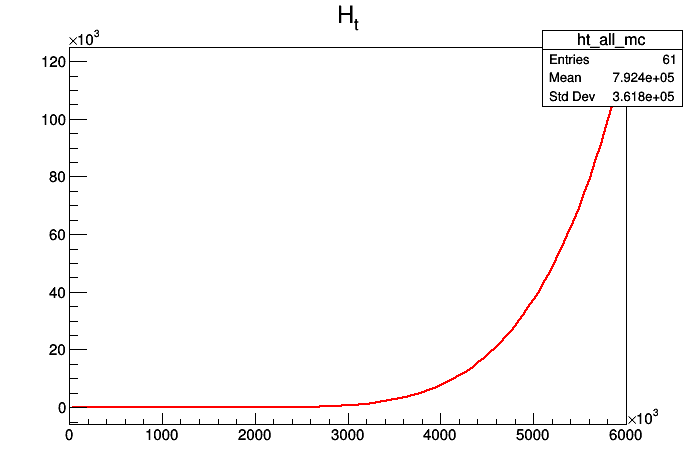

In [10]:
c2 = r.TCanvas()
ht_all_mc.Draw()
c2.Draw()

# Plot and draw testing area

## Jet pt

CPU times: user 138 ms, sys: 28.8 ms, total: 167 ms
Wall time: 256 ms


Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 30 points have been skipped
Info in <TCanvas::SaveAs>: ROOT file jet_pt_ttbar.root has been created


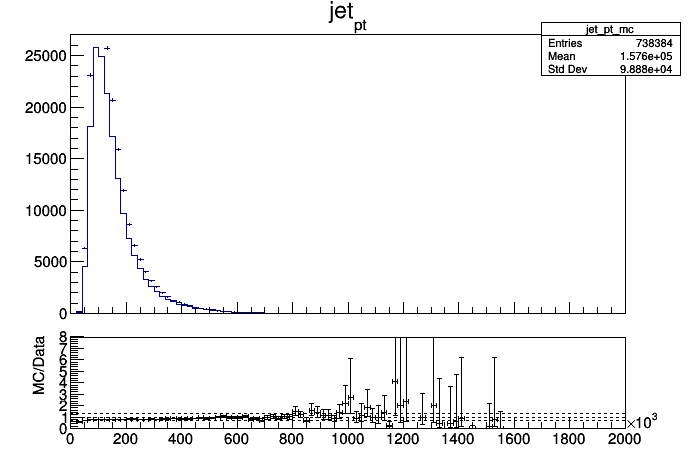

In [9]:
%%time
###
#Wrap Up
####
c_jet_pt = r.TCanvas()

#jet_pt_mc.Sumw2()
#jet_pt_data.Sumw2()
rp_jet_pt = r.TRatioPlot(jet_pt_mc, jet_pt_data)
rp_jet_pt.Draw()
jet_pt_upper_pad = rp_jet_pt.GetUpperPad()

lower_y_jetpt = rp_jet_pt.GetLowerRefYaxis()
rp_jet_pt.GetLowerPad().SetLogy(0)
lower_y_jetpt.SetTitle('MC/Data')
lower_y_jetpt.SetRangeUser(0,8)


c_jet_pt.Draw()
c_jet_pt.SaveAs('jet_pt_ttbar.root')

# ht 

CPU times: user 84.4 ms, sys: 41.5 ms, total: 126 ms
Wall time: 224 ms


Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 46 points have been skipped
Info in <TCanvas::SaveAs>: ROOT file ht_all_ttbar.root has been created


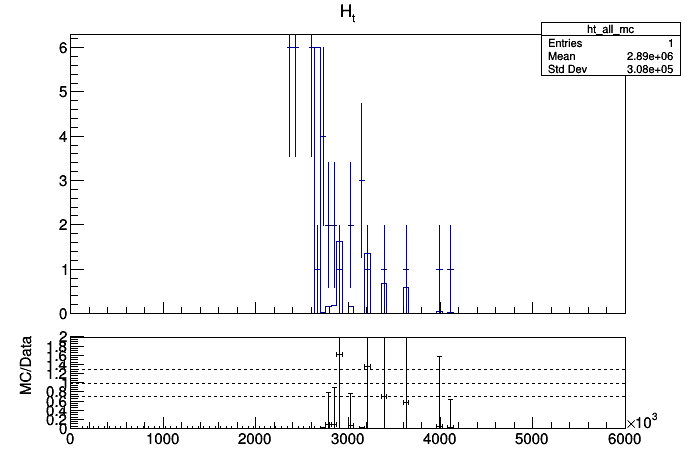

In [19]:
%%time
###
#Wrap Up
####
c_ht = r.TCanvas()

#jet_pt_mc.Sumw2()
#jet_pt_data.Sumw2()
rp_ht = r.TRatioPlot(ht_all_mc, ht_all_data)
rp_ht.Draw()
#ht_upper_pad = rp_ht.GetUpperPad()
#ht_log_upper_pad.SetLogy(1)
lower_y_ht_log = rp_ht.GetLowerRefYaxis()
#rp_ht.GetLowerPad().SetLogy(0)
lower_y_ht_log.SetTitle('MC/Data')
lower_y_ht_log.SetRangeUser(0,2)


c_ht.Draw()
c_ht.SaveAs('ht_all_ttbar.root')

## met

CPU times: user 8.25 ms, sys: 2.38 ms, total: 10.6 ms
Wall time: 11.1 ms


Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 35 points have been skipped
Info in <TCanvas::SaveAs>: ROOT file met_ttbar.root has been created


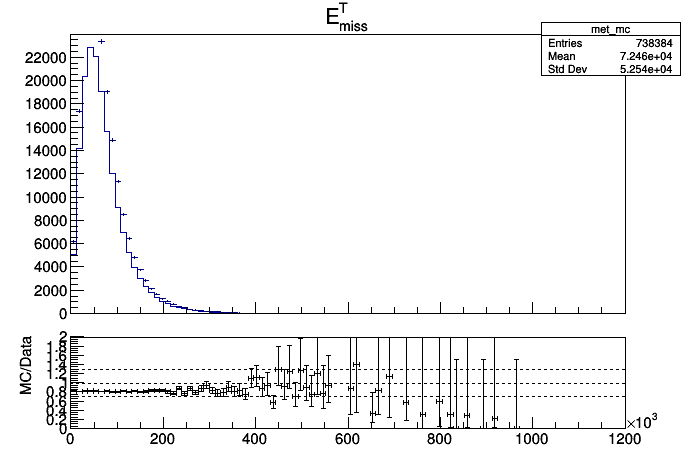

In [14]:
%%time
###
#Wrap Up
####
c_met = r.TCanvas()

#jet_pt_mc.Sumw2()
#jet_pt_data.Sumw2()
rp_met = r.TRatioPlot(met_mc, met_data)
rp_met.Draw()
met_upper_pad = rp_met.GetUpperPad()
#met_upper_pad.SetLogy(1)
lower_y_met = rp_met.GetLowerRefYaxis()
#rp_met.GetLowerPad().SetLogy(0)
lower_y_met.SetTitle('MC/Data')
lower_y_met.SetRangeUser(0,2)


c_met.Draw()
c_met.SaveAs('met_ttbar.root')

## bjets

CPU times: user 7.64 ms, sys: 1.91 ms, total: 9.56 ms
Wall time: 11.2 ms


Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 3 points have been skipped
Info in <TCanvas::SaveAs>: ROOT file bjets_bjets3.root has been created


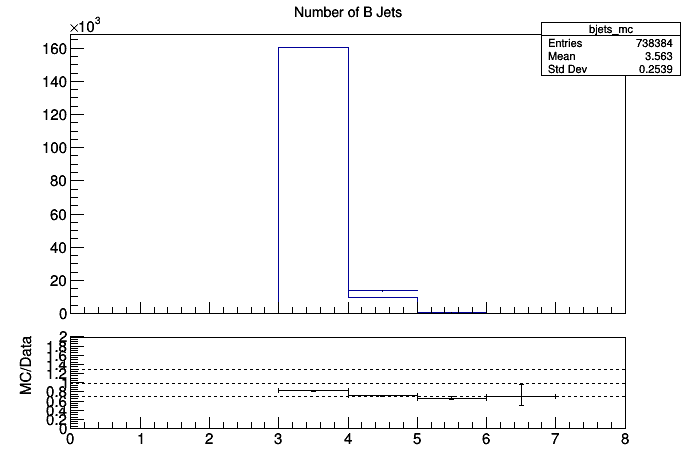

In [15]:
%%time
###
#Wrap Up
####
c_bjets = r.TCanvas()

#jet_pt_mc.Sumw2()
#jet_pt_data.Sumw2()
rp_bjets = r.TRatioPlot(bjets_mc, bjets_data)
rp_bjets.Draw()

lower_y_bjets = rp_bjets.GetLowerRefYaxis()
#rp_met.GetLowerPad().SetLogy(0)
lower_y_bjets.SetTitle('MC/Data')
lower_y_bjets.SetRangeUser(0,2)


c_bjets.Draw()
c_bjets.SaveAs('bjets_bjets3.root')

In [39]:
make_ratio_hists(met_bkg, met_data, 'met_test', draw=True)

Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 94 points have been skipped
Info in <TCanvas::SaveAs>: ROOT file met_test.root has been created


CPU times: user 91 ms, sys: 27.9 ms, total: 119 ms
Wall time: 125 ms


Info in <TCanvas::SaveAs>: ROOT file ht_correction_other.root has been created


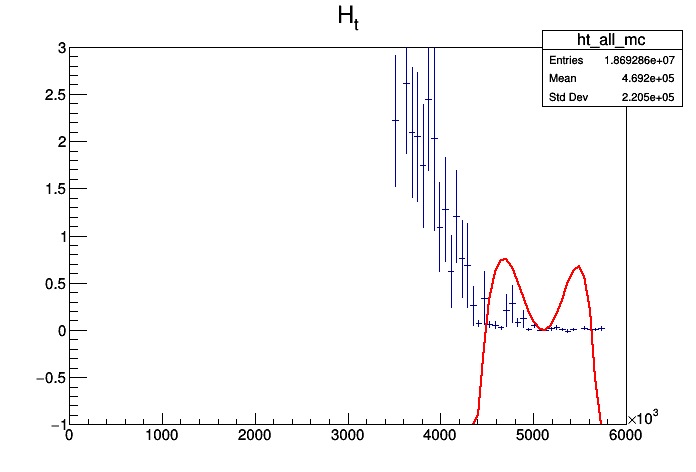

In [11]:
%%time
###
#Wrap Up
####
c_ht_corr = r.TCanvas()

#ht_all_mc.Sumw2()
#ht_all_data.Sumw2()


#ht_all_mc.Divide(ht_all_data)

ht_all_mc.Draw()
ht_all_mc.GetYaxis().SetRangeUser(-1,3)
c_ht_corr.Draw()
c_ht_corr.SaveAs('ht_correction_other.root')


****************************************
Minimizer is Linear
Chi2                      =  7.24726e+06
NDf                       =           88
p0                        =      26745.8   +/-   29.5963     
p1                        =   -0.0300952   +/-   3.50378e-05 
p2                        =  1.33348e-08   +/-   1.63844e-11 
p3                        = -2.91605e-15   +/-   3.7733e-18  
p4                        =  3.15339e-22   +/-   4.28153e-25 
p5                        = -1.35105e-29   +/-   1.91741e-32 


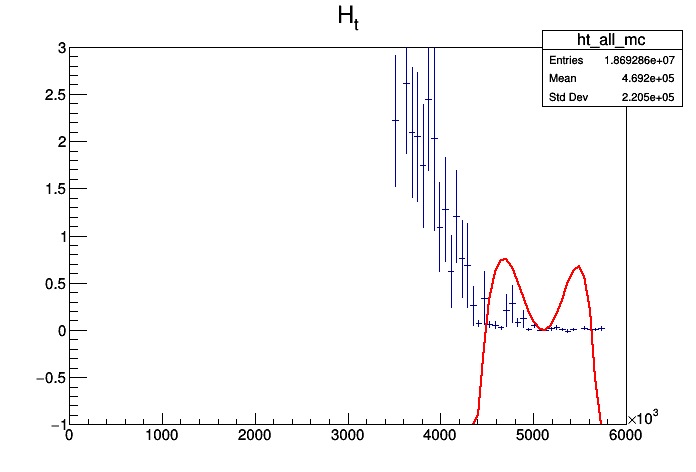

In [12]:
t_fit = ht_all_mc.Fit('pol5', 'S')
ht_all_mc.Draw()
c_ht_corr.Draw()

In [16]:
test_f = ht_all_mc.GetFunction("pol5")

test_f.Eval(1000)

26715.727693224253

In [16]:
l =  ht_all_mc.GetListOfFunctions()
print(l[0].name)

AttributeError: 'TPaveStats' object has no attribute 'name'

In [23]:
plot_file = r.TFile('ht_correction.root')
ht_all = plot_file.Get("c1")
ht_ratio = ht_all.GetPrimitive('ht_all_mc')
ht_ratio.Draw()

In [1]:
%%time
for jentry in range(data_entries):
    nb = data_chain.GetEntry(jentry)
    
    if nb<=0: continue
        
    #add requirement for >2 b tag jets 
    
    jet_pt = data_chain.jet_pt[0]
    met = data_chain.met_met
    
    #mu_pt = data_chain.mu_pt

    ht_all = data_chain.HT_all
    bjets_mc70 = data_chain.nBTags_MV2c10_70
    
        
    #add conditions here
    if (bjets_mc70 < 3): continue

    met_data.Fill(met)
    jet_pt_data.Fill(jet_pt)
    #mu_pt_data.Fill(mu_pt)
    ht_all_data.Fill(ht_all)
    bjets_data.Fill(bjets_mc70)


NameError: name 'data_entries' is not defined

In [6]:
%%time
for jentry in range(mc_entries):
    nb = mc_chain.GetEntry(jentry)
    
    if nb<=0: continue
        
    jet_pt = mc_chain.jet_pt[0]
    met = mc_chain.met_met
    #mu_pt = mc_chain.mu_pt
    ht_all = mc_chain.HT_all
    bjets_mc70 = mc_chain.nBTags_MV2c10_70
    
    #add conditions here
    if (bjets_mc70 < 3): continue
    
    
    weight = GetWeight(140, mc_chain)

    met_mc.Fill(met,weight)
    
    jet_pt_mc.Fill(jet_pt, weight)
    #mu_pt_mc.Fill(mu_pt, weight)
    ht_all_mc.Fill(ht_all, weight)
    bjets_mc.Fill(bjets_mc70, weight)
    


KeyboardInterrupt: 